# Master Process Only:

In [1]:
using Distributed
using LaTeXStrings
using KDTree
using CPUTime
using JLD2

Distributed.addprocs(4)

using PyPlot
plt = PyPlot

┌ Info: Precompiling KDTree [696f4745-383f-4cfb-8be8-c7582de6cd01]
└ @ Base loading.jl:1260


PyPlot

# Workers:

In [2]:
@everywhere begin 
    using Distributed
    using Distributions 
    using IntervalSets
    using ValueShapes
    using ArraysOfArrays
    using StatsBase 
    using LinearAlgebra
    using BATPar
    using BAT
end

In [3]:
@everywhere begin 
    g(x;) = prod(pdf.(Normal(), x))
    N = 2
    min_v = -10.
    max_v = 10.
    lgV = N*log(max_v-min_v); 
    likelihood = params -> LogDVal((log(g(params.a))))
end

In [4]:
@everywhere begin

    true_param =(μ1=4, μ2=-4, σ=0.13)

    function g(x::AbstractArray; true_param=true_param)
        tmp = 1
        for i in eachindex(x)
            if i > 2
                tmp *= pdf(Cauchy(true_param.μ1 + true_param.μ2, true_param.σ), x[i])
            else 
                tmp *= 0.5*pdf(Cauchy(true_param.μ1, true_param.σ), x[i]) + 0.5*pdf(Cauchy(true_param.μ2, true_param.σ), x[i])
            end
        end
        return tmp
    end

    function LogTrueIntegral(N; max = max_v, min=min_v,  true_param=true_param) 
        tmp = 0
        for i in 1:N
            if i > 2
                tmp += log(cdf(Cauchy(true_param.μ1 + true_param.μ2,true_param.σ), max_v) - cdf(Cauchy(true_param.μ1 + true_param.μ2,true_param.σ), min_v))
            else 
                tmp += log(cdf(Cauchy(true_param.μ1,true_param.σ), max_v) - cdf(Cauchy(true_param.μ1 ,true_param.σ), min_v))
            end
        end
        return tmp
    end

    N = 6
    min_v = -10.
    max_v = 10.
    lgV = N*log(max_v-min_v); 
    likelihood = params -> LogDVal((log(g(params.a))))
    
end
    

## Exploration samples: 

In [5]:
prior = NamedTupleDist(a = [[min_v .. max_v for i in 1:N]...],);
posterior = PosteriorDensity(likelihood, prior);

nnsamples = 450
nnchains = 75

samples, stats = bat_sample(posterior, (nnsamples, nnchains), MetropolisHastings(),);

smpl = flatview(unshaped.(samples.v))
weights_LogLik = samples.logd
weights_Histogram = samples.weight;

data_kdtree = Data(collect(smpl[:,1:5:end]), weights_Histogram[1:5:end], weights_LogLik[1:5:end]);

┌ Info: Trying to generate 75 viable MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:193
┌ Info: Selected 75 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:304
┌ Info: Begin tuning of 75 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:65
┌ Info: MCMC Tuning cycle 1 finished, 75 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ Info: MCMC Tuning cycle 2 finished, 75 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ Info: MCMC Tuning cycle 3 finished, 75 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ Info: MCMC Tuning cycle 4 finished, 75 chains, 1 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tu

# Space Partitioning

In [6]:
KDTree.evaluate_total_cost(data::Data) = KDTree.cost_f_1(data)

output, cost_array = DefineKDTree(data_kdtree, [1,2,3,4], 10);

extend_tree_bounds!(output, repeat([min_v], N), repeat([max_v], N))

┌ Info: KDTree: Increasing tree depth: depth = 1
└ @ KDTree /Users/vhafych/MPP-Server/gitrepos/KDTree/src/KDTree.jl:183
┌ Info: KDTree: Increasing tree depth: depth = 2
└ @ KDTree /Users/vhafych/MPP-Server/gitrepos/KDTree/src/KDTree.jl:183
┌ Info: KDTree: Increasing tree depth: depth = 3
└ @ KDTree /Users/vhafych/MPP-Server/gitrepos/KDTree/src/KDTree.jl:183
┌ Info: KDTree: Increasing tree depth: depth = 4
└ @ KDTree /Users/vhafych/MPP-Server/gitrepos/KDTree/src/KDTree.jl:183
┌ Info: KDTree: Increasing tree depth: depth = 5
└ @ KDTree /Users/vhafych/MPP-Server/gitrepos/KDTree/src/KDTree.jl:183
┌ Info: KDTree: Increasing tree depth: depth = 6
└ @ KDTree /Users/vhafych/MPP-Server/gitrepos/KDTree/src/KDTree.jl:183
┌ Info: KDTree: Increasing tree depth: depth = 7
└ @ KDTree /Users/vhafych/MPP-Server/gitrepos/KDTree/src/KDTree.jl:183
┌ Info: KDTree: Increasing tree depth: depth = 8
└ @ KDTree /Users/vhafych/MPP-Server/gitrepos/KDTree/src/KDTree.jl:183
┌ Info: KDTree: Increasing tree depth: d

# Sampling of subspaces 

In [7]:
bounds_part = extract_par_bounds(output)

@everywhere BATPar.make_named_prior(i) = BAT.NamedTupleDist( a =  [[i[j,1]..i[j,2] for j in 1:size(i)[1]]...])

nnsamples = 10^4
nnchains = 10

tuning = AdaptiveMetropolisTuning(
    λ = 0.5,
    α = 0.15..0.35,
    β = 1.5,
    c = 1e-4..1e2
)

burnin = MCMCBurninStrategy(
    max_nsamples_per_cycle = 4000,
    max_nsteps_per_cycle = 4000,
    max_time_per_cycle = 25,
    max_ncycles = 200
)

algorithm = MetropolisHastings();

@time samples_parallel = bat_sample_parallel(likelihood, bounds_part, (nnsamples, nnchains), algorithm, tuning=tuning, burnin=burnin);

[ Info: BATPar: Sampling subspace 1:
[ Info: BATPar: Sampling subspace 3:
[ Info: BATPar: Sampling subspace 4:
[ Info: BATPar: Sampling subspace 2:
[ Info: Trying to generate 10 viable MCMC chain(s).
[ Info: Trying to generate 10 viable MCMC chain(s).
[ Info: Trying to generate 10 viable MCMC chain(s).
[ Info: Trying to generate 10 viable MCMC chain(s).
[ Info: Selected 10 MCMC chain(s).
[ Info: Selected 10 MCMC chain(s).
[ Info: Selected 10 MCMC chain(s).
[ Info: Selected 10 MCMC chain(s).
[ Info: Begin tuning of 10 MCMC chain(s).
[ Info: Begin tuning of 10 MCMC chain(s).
[ Info: Begin tuning of 10 MCMC chain(s).
[ Info: Begin tuning of 10 MCMC chain(s).
[ Info: MCMC Tuning cycle 1 finished, 10 chains, 0 tuned, 0 converged.
[ Info: MCMC Tuning cycle 1 finished, 10 chains, 0 tuned, 0 converged.
[ Info: MCMC Tuning cycle 2 finished, 10 chains, 0 tuned, 0 converged.
[ Info: MCMC Tuning cycle 3 finished, 10 chains, 0 tuned, 0 converged.
[ Info: MCMC Tuning cycle 4 finished, 10 chains, 0 t

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


[ Info: Updating 54 Hyperrectangles using 8 thread(s)
[ Info: Integrating 54 Hyperrectangles


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


[ Info: Estimating Uncertainty (cov. weighted result)
[ Info: Create 66 Hyperrectangles using 8 thread(s)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


[ Info: Updating 64 Hyperrectangles using 8 thread(s)
[ Info: Integrating 64 Hyperrectangles
[ Info: Updating 61 Hyperrectangles using 8 thread(s)
[ Info: Integrating 61 Hyperrectangles


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


[ Info: Estimating Uncertainty (cov. weighted result)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


[ Info: Estimating Uncertainty (cov. weighted result)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


[ Info: Updating 66 Hyperrectangles using 8 thread(s)
[ Info: Integrating 66 Hyperrectangles


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


[ Info: Estimating Uncertainty (cov. weighted result)
[ Info: BATPar: Sampling subspace 5:
[ Info: Trying to generate 10 viable MCMC chain(s).
[ Info: Selected 10 MCMC chain(s).
[ Info: Begin tuning of 10 MCMC chain(s).
[ Info: MCMC Tuning cycle 1 finished, 10 chains, 0 tuned, 0 converged.
[ Info: MCMC Tuning cycle 2 finished, 10 chains, 0 tuned, 0 converged.
[ Info: MCMC Tuning cycle 3 finished, 10 chains, 0 tuned, 0 converged.
[ Info: BATPar: Sampling subspace 6:
[ Info: Trying to generate 10 viable MCMC chain(s).
[ Info: Selected 10 MCMC chain(s).
[ Info: Begin tuning of 10 MCMC chain(s).
[ Info: BATPar: Sampling subspace 7:
[ Info: Trying to generate 10 viable MCMC chain(s).
[ Info: MCMC Tuning cycle 1 finished, 10 chains, 0 tuned, 0 converged.
[ Info: Selected 10 MCMC chain(s).
[ Info: Begin tuning of 10 MCMC chain(s).
[ Info: MCMC Tuning cycle 2 finished, 10 chains, 0 tuned, 0 converged.
[ Info: MCMC Tuning cycle 3 finished, 10 chains, 0 tuned, 0 converged.
[ Info: MCMC Tuning cy

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


[ Info: MCMC Tuning cycle 25 finished, 10 chains, 10 tuned, 0 converged.
[ Info: Determine Hyperrectangle Starting Samples
[ Info: MCMC Tuning cycle 26 finished, 10 chains, 10 tuned, 0 converged.
[ Info: MCMC Tuning cycle 27 finished, 10 chains, 10 tuned, 0 converged.
[ Info: Determine Tolerances for Hyperrectangle Creation
[ Info: MCMC Tuning cycle 9 finished, 10 chains, 10 tuned, 0 converged.
[ Info: MCMC Tuning cycle 28 finished, 10 chains, 9 tuned, 0 converged.
[ Info: MCMC Tuning cycle 10 finished, 10 chains, 9 tuned, 10 converged.
[ Info: MCMC Tuning cycle 29 finished, 10 chains, 10 tuned, 0 converged.
[ Info: MCMC Tuning cycle 11 finished, 10 chains, 10 tuned, 10 converged.
[ Info: MCMC tuning of 10 chains successful after 11 cycle(s).
[ Info: MCMC Tuning cycle 30 finished, 10 chains, 9 tuned, 0 converged.
[ Info: MCMC Tuning cycle 31 finished, 10 chains, 10 tuned, 0 converged.
[ Info: MCMC Tuning cycle 32 finished, 10 chains, 9 tuned, 0 converged.
[ Info: MCMC Tuning cycle 33 f

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


[ Info: Updating 60 Hyperrectangles using 8 thread(s)
[ Info: Integrating 60 Hyperrectangles
[ Info: Create 66 Hyperrectangles using 8 thread(s)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


[ Info: Estimating Uncertainty (cov. weighted result)
[ Info: BATPar: Sampling subspace 9:
[ Info: Trying to generate 10 viable MCMC chain(s).
[ Info: Selected 10 MCMC chain(s).
[ Info: Begin tuning of 10 MCMC chain(s).
[ Info: MCMC Tuning cycle 1 finished, 10 chains, 0 tuned, 0 converged.
[ Info: MCMC Tuning cycle 2 finished, 10 chains, 0 tuned, 0 converged.
[ Info: Harmonic Mean Integration started. Samples in dataset 1 / 2: 	50000 / 49999	Parameters:	6
[ Info: Data Whitening.
[ Info: Apply Whitening Transformation to Data Set 2
[ Info: Create Space Partitioning Tree
[ Info: MCMC Tuning cycle 3 finished, 10 chains, 0 tuned, 0 converged.
[ Info: Determine Hyperrectangle Starting Samples
[ Info: MCMC Tuning cycle 4 finished, 10 chains, 0 tuned, 0 converged.
[ Info: MCMC Tuning cycle 5 finished, 10 chains, 0 tuned, 0 converged.
[ Info: Determine Tolerances for Hyperrectangle Creation
[ Info: MCMC Tuning cycle 6 finished, 10 chains, 1 tuned, 10 converged.
[ Info: MCMC Tuning cycle 7 fini

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


[ Info: Updating 66 Hyperrectangles using 8 thread(s)
[ Info: Integrating 66 Hyperrectangles
[ Info: Estimating Uncertainty (cov. weighted result)
[ Info: BATPar: Sampling subspace 10:
[ Info: Trying to generate 10 viable MCMC chain(s).
[ Info: MCMC Tuning cycle 8 finished, 10 chains, 4 tuned, 10 converged.
[ Info: Selected 10 MCMC chain(s).
[ Info: Begin tuning of 10 MCMC chain(s).
[ Info: MCMC Tuning cycle 9 finished, 10 chains, 8 tuned, 0 converged.
[ Info: MCMC Tuning cycle 1 finished, 10 chains, 0 tuned, 0 converged.
[ Info: MCMC Tuning cycle 10 finished, 10 chains, 9 tuned, 0 converged.
[ Info: MCMC Tuning cycle 11 finished, 10 chains, 10 tuned, 0 converged.
[ Info: MCMC Tuning cycle 2 finished, 10 chains, 0 tuned, 0 converged.
[ Info: MCMC Tuning cycle 3 finished, 10 chains, 0 tuned, 0 converged.


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


[ Info: MCMC Tuning cycle 12 finished, 10 chains, 10 tuned, 0 converged.
[ Info: Updating 56 Hyperrectangles using 8 thread(s)
[ Info: MCMC Tuning cycle 4 finished, 10 chains, 0 tuned, 0 converged.


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


[ Info: MCMC Tuning cycle 13 finished, 10 chains, 9 tuned, 0 converged.
[ Info: Integrating 56 Hyperrectangles
[ Info: Estimating Uncertainty (cov. weighted result)
[ Info: MCMC Tuning cycle 5 finished, 10 chains, 0 tuned, 0 converged.
[ Info: MCMC Tuning cycle 14 finished, 10 chains, 10 tuned, 0 converged.
[ Info: MCMC Tuning cycle 6 finished, 10 chains, 0 tuned, 10 converged.
[ Info: BATPar: Sampling subspace 11:
[ Info: Trying to generate 10 viable MCMC chain(s).
[ Info: Selected 10 MCMC chain(s).
[ Info: Begin tuning of 10 MCMC chain(s).
[ Info: MCMC Tuning cycle 1 finished, 10 chains, 0 tuned, 0 converged.
[ Info: MCMC Tuning cycle 2 finished, 10 chains, 0 tuned, 0 converged.
[ Info: MCMC Tuning cycle 7 finished, 10 chains, 4 tuned, 10 converged.
[ Info: MCMC Tuning cycle 15 finished, 10 chains, 10 tuned, 10 converged.
[ Info: MCMC tuning of 10 chains successful after 15 cycle(s).
[ Info: MCMC Tuning cycle 3 finished, 10 chains, 0 tuned, 0 converged.
[ Info: MCMC Tuning cycle 8 fi

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


[ Info: Harmonic Mean Integration started. Samples in dataset 1 / 2: 	50000 / 49999	Parameters:	6
[ Info: Data Whitening.
[ Info: Apply Whitening Transformation to Data Set 2
[ Info: Create Space Partitioning Tree
[ Info: Determine Hyperrectangle Starting Samples
[ Info: Updating 48 Hyperrectangles using 8 thread(s)
[ Info: Determine Tolerances for Hyperrectangle Creation


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


[ Info: Integrating 48 Hyperrectangles
[ Info: Estimating Uncertainty (cov. weighted result)
[ Info: Harmonic Mean Integration started. Samples in dataset 1 / 2: 	50000 / 49999	Parameters:	6
[ Info: Data Whitening.
[ Info: Apply Whitening Transformation to Data Set 2
[ Info: Create Space Partitioning Tree
[ Info: Harmonic Mean Integration started. Samples in dataset 1 / 2: 	50000 / 49999	Parameters:	6
[ Info: Data Whitening.
[ Info: Apply Whitening Transformation to Data Set 2
[ Info: Create Space Partitioning Tree
[ Info: Determine Hyperrectangle Starting Samples
[ Info: Determine Tolerances for Hyperrectangle Creation
[ Info: Determine Hyperrectangle Starting Samples
[ Info: Determine Tolerances for Hyperrectangle Creation
[ Info: Create 57 Hyperrectangles using 8 thread(s)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


[ Info: Updating 57 Hyperrectangles using 8 thread(s)
[ Info: Integrating 57 Hyperrectangles
[ Info: Estimating Uncertainty (cov. weighted result)
[ Info: Create 48 Hyperrectangles using 8 thread(s)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


[ Info: Updating 48 Hyperrectangles using 8 thread(s)
[ Info: Integrating 48 Hyperrectangles
[ Info: Estimating Uncertainty (cov. weighted result)
[ Info: Create 74 Hyperrectangles using 8 thread(s)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


[ Info: Updating 74 Hyperrectangles using 8 thread(s)
[ Info: Integrating 74 Hyperrectangles
[ Info: Estimating Uncertainty (cov. weighted result)
┌ Info: BATPar: Sampling is finished. Combining samples:
└ @ BATPar /Users/vhafych/MPP-Server/gitrepos/BATPar.jl/src/BATPar.jl:58
┌ Info: BATPar: Ready!
└ @ BATPar /Users/vhafych/MPP-Server/gitrepos/BATPar.jl/src/BATPar.jl:75


 76.934299 seconds (29.65 M allocations: 1.793 GiB, 0.83% gc time)


In [8]:
smpl_par = hcat(samples_parallel.samples...)
x = smpl_par[1,:]
y = smpl_par[2,:]
w_o = samples_parallel.weights_o
w_r =  samples_parallel.weights_r;

In [9]:
@show exp(LogTrueIntegral(N))

exp(LogTrueIntegral(N)) = 0.9483417417341203


0.9483417417341203

In [10]:
[sum(samples_parallel.integrals), sqrt(sum((samples_parallel.uncertainty).^2))]

2-element Array{Float64,1}:
 0.9209599166358132
 0.004986242214967336

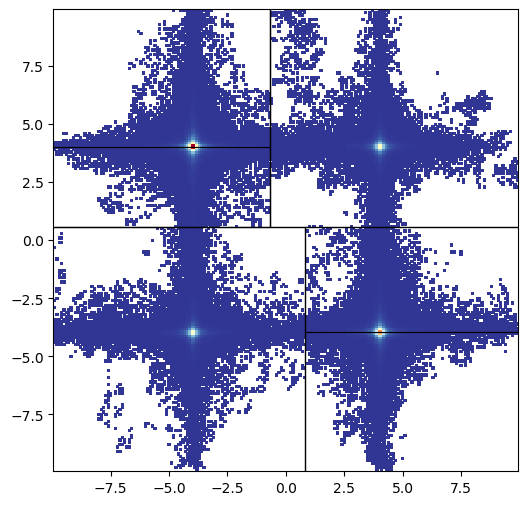

PyObject <matplotlib.patches.Rectangle object at 0x19e5d36d0>

In [11]:
histogram_2D_r = fit(Histogram, (x,y), weights(w_o), nbins=200)
histogram_2D_r = normalize(histogram_2D_r, mode=:probability)

fig, ax = plt.subplots(1,1, figsize=(6, 6))

img = ax.pcolormesh(midpoints(histogram_2D_r.edges[1]), midpoints(histogram_2D_r.edges[2]), replace(histogram_2D_r.weights', 0=>NaN), cmap="RdYlBu_r") #terrain_r  vmin = -0.0001, vmax=maximum_v,
# fig.colorbar(img)

plot_tree(output, [1,2], ax, linewidth=0.8, color="black", alpha=1)

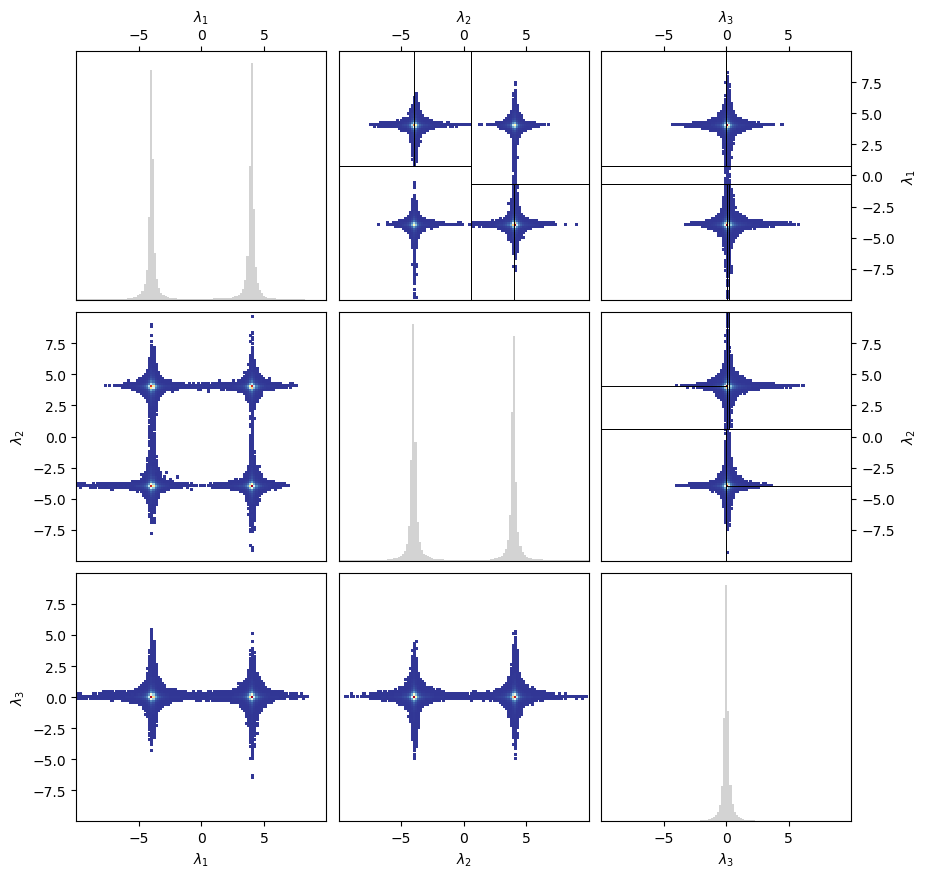

In [12]:
function corner_plots(samples::AbstractArray, tree::Node, sample_weights_r::AbstractArray, sample_weights_o::AbstractArray, dim_indices::AbstractArray, dim_names::AbstractArray;
        save_plot=false,
        FILE_NAME = "density_function.pdf",
        N_bins = 100,
        levels_quantiles = [0.4, 0.7, 0.8, 0.9, 0.99, 1,], 
        hist_color = plt.cm.tab10(1), 
        colors = vcat([0 0 0 0.3], plt.cm.YlOrRd(range(0, stop=1, length=10))[2:end,:]),  #vcat([1 1 1 1], plt.cm.Blues(range(0, stop=1, length=20))[2:end,:]),
        kwargs...,
    )
    
    N = length(dim_indices)
    bins=[]
    fig, ax = plt.subplots(N,N, figsize=(10, 10))
    fig.subplots_adjust(wspace=0.05, hspace=0.05)
    
    for idx in 1:N
        dim_idx = dim_indices[idx]
        bins_tmp = range(minimum(samples[dim_idx,:]), stop=maximum(samples[dim_idx,:]), length=N_bins)
        push!(bins, bins_tmp)
#         ax[idx, idx].hist(samples[dim_idx,:], weights=sample_weights_o/sum(sample_weights_o), bins=bins_tmp, color=hist_color, alpha=0.4)
        ax[idx, idx].hist(samples[dim_idx,:], weights=sample_weights_r/sum(sample_weights_r), bins=bins_tmp,  color="lightgray", alpha=1, linewidth=0.9) #histtype="step",
        ax[idx, idx].set_xlim(first(bins_tmp),last(bins_tmp))
    end
    
    for i in 2:N, j in 1:(i-1)
        
        dim_x = dim_indices[j]
        dim_y = dim_indices[i]
        
        histogram_2D_r = fit(Histogram, (samples[dim_x,:],samples[dim_y,:]), weights(sample_weights_r), (bins[j], bins[i]))
        histogram_2D_r = normalize(histogram_2D_r, mode=:probability)
        
        histogram_2D_o = fit(Histogram, (samples[dim_y,:],samples[dim_x,:]), weights(sample_weights_o), (bins[i], bins[j]))
        histogram_2D_o = normalize(histogram_2D_o, mode=:probability)
        
#         levels=quantile([histogram_2D_r.weights...], levels_quantiles)
        min_v_1 = minimum(histogram_2D_r.weights[histogram_2D_r.weights .> 0])
        ax[i,j].pcolormesh(midpoints(histogram_2D_r.edges[1]), midpoints(histogram_2D_r.edges[2]), replace( x-> x<500*min_v_1 ? NaN : x, histogram_2D_r.weights'), cmap="RdYlBu_r" , rasterized=true) #bottom | ColorMap(colors) "RdYlBu_r"
        ax[i,j].set_xlim(first(bins[j]),last(bins[j]))
        ax[i,j].set_ylim(first(bins[i]),last(bins[i]))
        
        min_v_2 = minimum(histogram_2D_o.weights[histogram_2D_o.weights .> 0])
        ax[j,i].pcolormesh(midpoints(histogram_2D_o.edges[1]), midpoints(histogram_2D_o.edges[2]), replace( x-> x<300*min_v_2 ? NaN : x, histogram_2D_o.weights'),  cmap="RdYlBu_r" , rasterized=true) # top
        plot_tree(tree, [dim_y,dim_x], ax[j,i]; kwargs...,)
        
        ax[j,i].set_xlim(first(bins[i]),last(bins[i]))
        ax[j,i].set_ylim(first(bins[j]),last(bins[j]))
        
        
    end
    
    for i in 1:N, j in 1:N
        if 1<i<N 
            ax[i,j].get_xaxis().set_visible(false)
        elseif i==1 
            ax[i,j].xaxis.tick_top()
            ax[i,j].xaxis.set_label_position("top")
            ax[i,j].set_xlabel(dim_names[j])
        else
            ax[i,j].set_xlabel(dim_names[j]) 
        end
        
        if j == i || N>j>1
            # nothing inside 
            ax[i,j].get_yaxis().set_visible(false) 
        elseif j==N
            # right labels
            ax[i,j].set_ylabel(dim_names[i])
            ax[i,j].yaxis.set_label_position("right")
            ax[i,j].yaxis.tick_right()
        else
            #left labels
            ax[i,j].set_ylabel(dim_names[i])
        end
    end
    
    if save_plot 
        fig.savefig(FILE_NAME, bbox_inches = "tight", ) #dpi=500 
    end
        
end

corner_plots(smpl_par, output, w_r, w_o, 
    [1,2,3], [L"\lambda_1", L"\lambda_2", L"\lambda_3", L"\lambda_4",  L"\lambda_5"], 
    N_bins=120, linewidth=0.6, color="black",
    save_plot=false,
    FILE_NAME = "../../MCMC_publication/fig-f-2-a.png",
    )

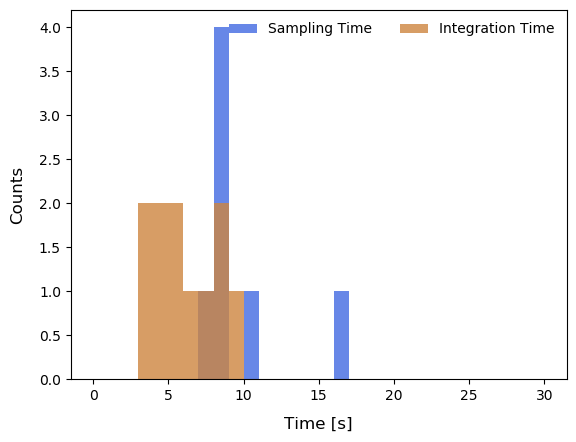

PyObject Text(25.000000000000004, 0.5, 'Counts')

In [13]:
bins=collect(0:1:30)
plt.hist(samples_parallel.time_mcmc, bins, color="royalblue", label = "Sampling Time", alpha=0.8);
plt.hist(samples_parallel.time_integration, bins, color="peru", label = "Integration Time", alpha=0.8);

plt.legend(loc="upper right", frameon=false, framealpha=0.8, ncol=2, )
plt.xlabel("Time [s]", labelpad=10,  size=12)
plt.ylabel("Counts", labelpad=10,  size=12)

In [14]:
sum(samples_parallel.time_mcmc) + sum(samples_parallel.time_integration)

283.743237

In [15]:
proc_ids = sort(unique(samples_parallel.proc_id))

tmp = [sum(samples_parallel.proc_id .== i) for i in proc_ids]

min_subspaces = minimum(tmp)
max_subspaces = maximum(tmp)

proc_names = ["Worker #$i" for i in proc_ids]
proc_sampling_sum = [sum(samples_parallel.time_mcmc[samples_parallel.proc_id .== i]) for i in proc_ids]
proc_int_sum = [sum(samples_parallel.time_integration[samples_parallel.proc_id .== i]) for i in proc_ids]

proc_pos = collect(1:1:length(proc_ids));
delta = 0.7 / max_subspaces

sampling_times = [samples_parallel.time_mcmc[samples_parallel.proc_id .== i] for i in proc_ids]
int_times = [samples_parallel.time_integration[samples_parallel.proc_id .== i] for i in proc_ids]

fin_positions = maximum.([cumsum(i) for i in (sampling_times .+ int_times)]);

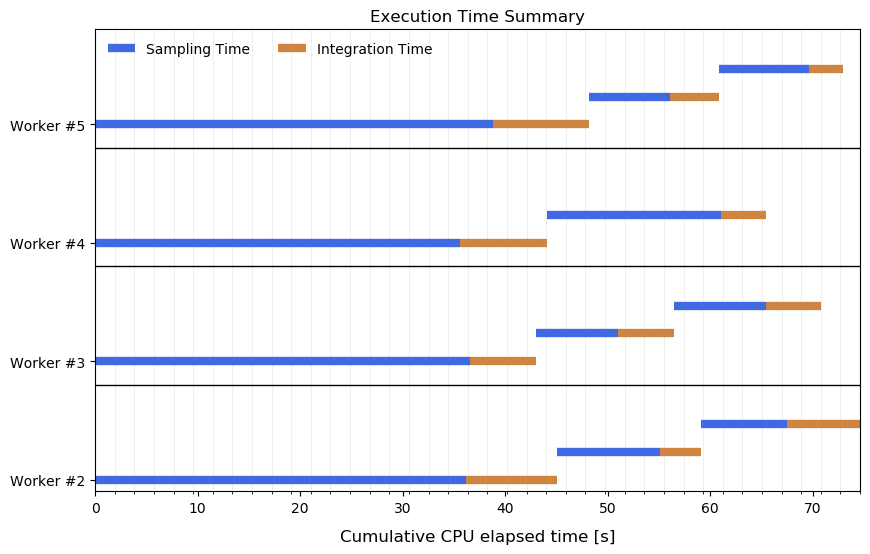

In [16]:
fig, ax = plt.subplots(figsize=(10, 6))
fig.subplots_adjust(left=0.115, right=0.88)

label_1 = "Sampling Time"
label_2 = "Integration Time"

for p in 1:1:length(proc_names)
    n_subspaces = 1:1:length(sampling_times[p])
    
    cum_sum_int = cumsum(pushfirst!(sampling_times[p]+int_times[p], 0))
    
    ax.hlines([proc_pos[p] + (i-1)*delta for i in n_subspaces], cum_sum_int[1:end-1], cum_sum_int[1:end-1] .+sampling_times[p], color="royalblue", lw=6,  label=label_1)
    ax.hlines([proc_pos[p] + (i-1)*delta for i in n_subspaces], cum_sum_int[2:end] .- int_times[p], cum_sum_int[2:end], color="peru", lw=6, label=label_2)
    
    label_1 = "_nolegend_"
    label_2 = "_nolegend_"

    
end

ax.hlines(proc_pos[1:end-1].+0.8, 0, maximum(fin_positions), color="black", ls="-", lw=1, alpha=1)
ax.set_xlim(0, maximum(fin_positions))
ax.set_ylim(0.9, maximum(proc_pos)+0.8)

ax.set_yticks(proc_pos)
ax.set_yticklabels(proc_names)

ax.legend(loc="upper left", frameon=false, framealpha=0.8, ncol=2)
ax.set_xlabel("Cumulative CPU elapsed time [s]", labelpad=10,  size=12)
ax.set_title("Execution Time Summary",  size=12);


ax.set_xticks( range(0, stop=maximum(fin_positions), length=40), minor=true)
ax.grid(axis="x", which="minor", alpha=0.2, )

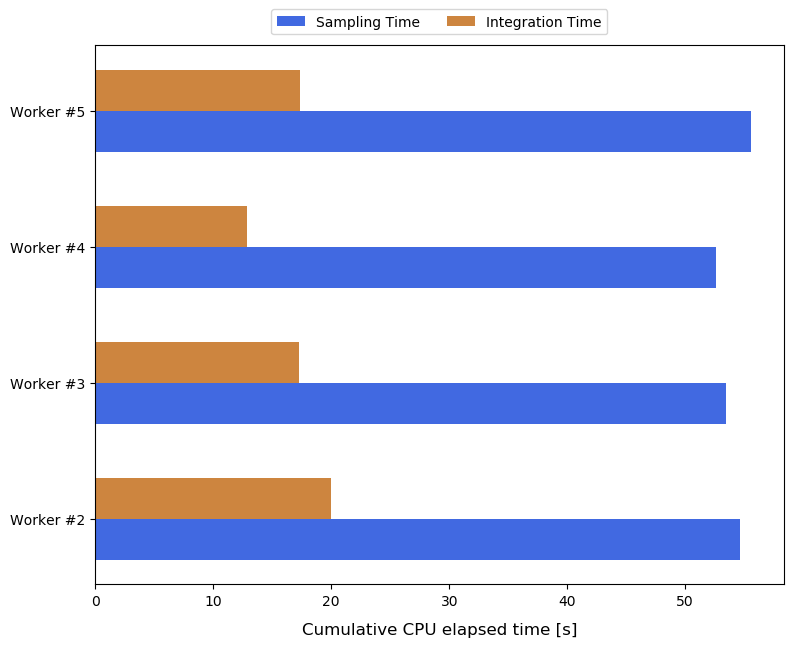

PyObject Text(0.5, 25.000000000000004, 'Cumulative CPU elapsed time [s]')

In [17]:
fig, ax1 = plt.subplots(figsize=(9, 7))
fig.subplots_adjust(left=0.115, right=0.88)


ax1.barh(proc_pos, proc_sampling_sum, color="royalblue",
                     align="center",
                     height=0.3,
                     label="Sampling Time")

ax1.barh(proc_pos .+ 0.3, proc_int_sum, color="peru",
                     align="center",
                     height=0.3,
                     label="Integration Time")

ax1.set_yticks(proc_pos.+0.15)
ax1.set_yticklabels(proc_names)

ax1.legend(loc="upper center", frameon=true, framealpha=0.8, ncol=2, bbox_to_anchor=(0.5, 1.08))

ax1.set_xlabel("Cumulative CPU elapsed time [s]", labelpad=10,  size=12)

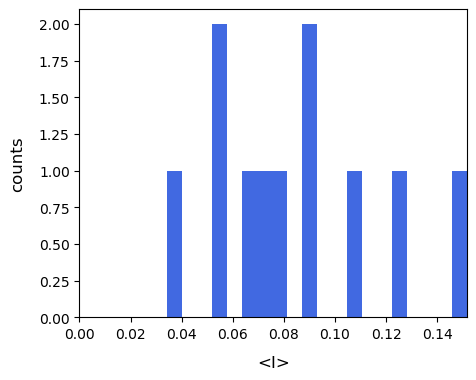

In [18]:
fig, ax = plt.subplots(figsize=(5, 4))

fig.subplots_adjust(hspace=0.03, wspace=0.03)

ax.hist(samples_parallel.integrals, bins=20, color="royalblue")
# ax.set_title("# Tweets")
# ax.axis("equal");

ax.set_xlabel("<I>", labelpad=10,  size=12)
ax.set_ylabel("counts", labelpad=10,  size=12)

ax.set_xlim(0, maximum(samples_parallel.integrals));

In [19]:
minimum_tmp = minimum(minimum(samples_parallel.timestamps))

int_data = [(i .- minimum_tmp)*10^-9  for i in samples_parallel.timestamps];

maximum_wc_time = maximum(maximum(int_data))
maximum_cpu_time = maximum([samples_parallel.time_mcmc..., samples_parallel.time_integration...])

38.844582

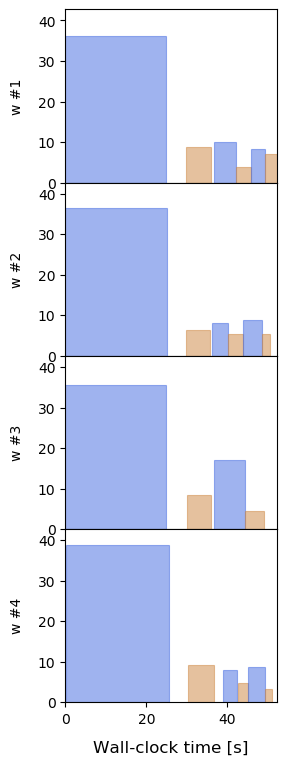

PyObject Text(0.5, 25.000000000000004, 'Wall-clock time [s]')

In [20]:
proc_ids = sort(unique(samples_parallel.proc_id))
n_workers = length(proc_ids)

x_min = 0
x_max = maximum_wc_time
y_min = 0
y_max = maximum_cpu_time + 0.1*maximum_cpu_time

# x_min = 0
# x_max = maximum_wc_time
# y_min = 0
# y_max = 10

fig, ax = plt.subplots(n_workers,1, sharex=true, figsize=(n_workers*3, 9))
fig.subplots_adjust(hspace=0.0, wspace=0.00)
# fig.text(0.0, 0.5, "common Y", va="center", rotation="vertical")

for (i,j) in enumerate(int_data)
    
    r1 = matplotlib.patches.Rectangle([j[1], 0.0], j[2]-j[1], samples_parallel.time_mcmc[i], fill=true, linewidth=0.8, color="royalblue", alpha=0.5) 
    ax[samples_parallel.proc_id[i] - 1].add_patch(r1)
    
    r2 = matplotlib.patches.Rectangle([j[3], 0.0], j[4]-j[3], samples_parallel.time_integration[i], fill=true, linewidth=0.8, color="peru", alpha=0.5) 
    ax[samples_parallel.proc_id[i] - 1].add_patch(r2)
end

for i in 1:n_workers
    ax[i].set_xlim(x_min, x_max);
    ax[i].set_ylim(y_min, y_max);
    ax[i].axes.set_aspect("equal")
    ax[i].set_ylabel("w #$i", labelpad=10,  size=10)
    
    if i<n_workers
        ax[i].get_xaxis().set_visible(false) 
    end
end


ax[n_workers].set_xlabel("Wall-clock time [s]", labelpad=10,  size=12)

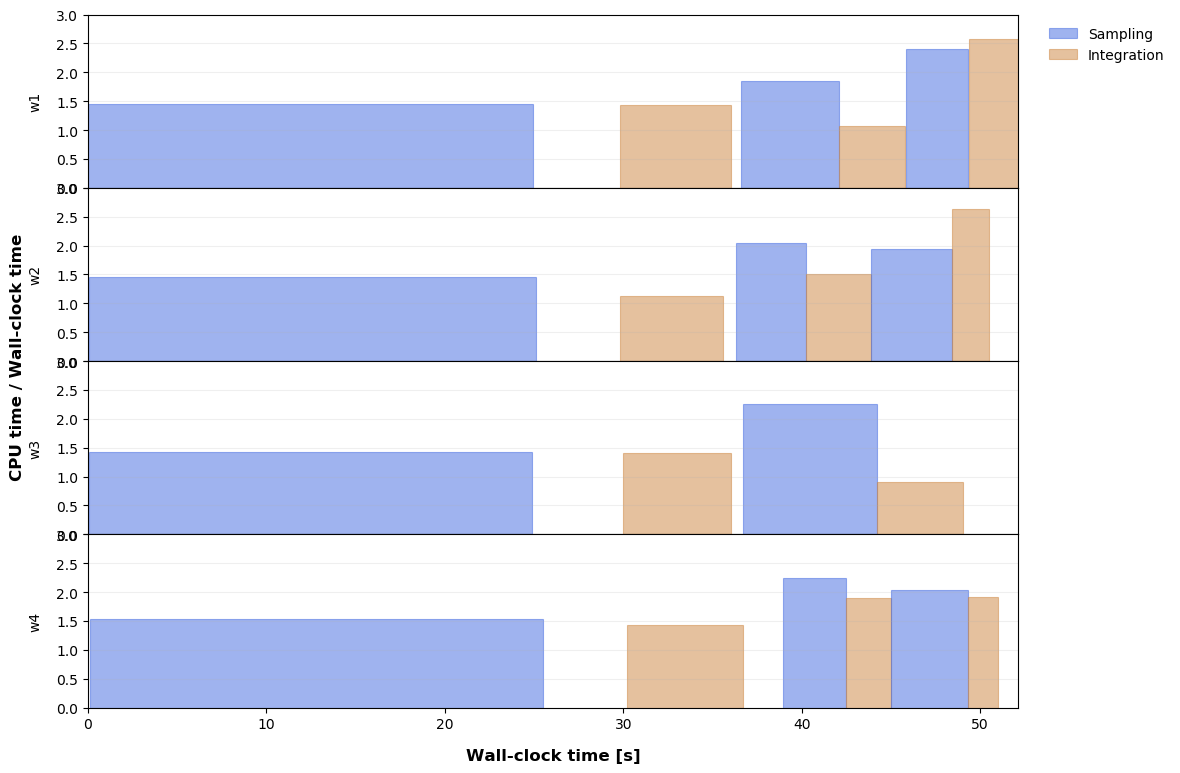

PyObject Text(0.5, 24.999999999999996, 'Wall-clock time [s]')

In [21]:
samples_ps = samples_parallel 

minimum_tmp = minimum(minimum(samples_ps.timestamps))

int_data = [(i .- minimum_tmp)*10^-9  for i in samples_ps.timestamps];

maximum_wc_time = maximum(maximum(int_data))
maximum_cpu_time = maximum([samples_ps.time_mcmc..., samples_ps.time_integration...])

proc_ids = sort(unique(samples_ps.proc_id))
n_workers = length(proc_ids)

x_min = 0
x_max = maximum_wc_time
y_min = 0
y_max = maximum_cpu_time + 0.1*maximum_cpu_time

# x_min = 0
# x_max = maximum_wc_time
# y_min = 0
# y_max = 10

label_1 = "Sampling"
label_2 = "Integration"

fig, ax = plt.subplots(n_workers,1, sharex=true, figsize=(n_workers*3, 9))
fig.subplots_adjust(hspace=0.0, wspace=0.00)
# fig.text(0.0, 0.5, "common Y", va="center", rotation="vertical")

y_max_tmp = []

for (i,j) in enumerate(int_data)

    r1 = matplotlib.patches.Rectangle([j[1], 0.0], j[2]-j[1], samples_ps.time_mcmc[i]/(j[2]-j[1]), fill=true, 
        linewidth=0.8, color="royalblue", alpha=0.5, label=label_1) 
    ax[samples_ps.proc_id[i] - 1].add_patch(r1)
    
    r2 = matplotlib.patches.Rectangle([j[3], 0.0], j[4]-j[3], samples_ps.time_integration[i]/(j[4]-j[3]), 
        fill=true, linewidth=0.8, color="peru", alpha=0.5, label=label_2) 
    ax[samples_ps.proc_id[i] - 1].add_patch(r2)
    
    
    push!(y_max_tmp, samples_ps.time_mcmc[i]/(j[2]-j[1]))
    push!(y_max_tmp, samples_ps.time_integration[i]/(j[4]-j[3]))
    
    if i==1; ax[samples_ps.proc_id[i] - 1].legend(loc="upper left", frameon=false, framealpha=0.8, ncol=1, bbox_to_anchor=(1.02, 1.0),); end
    
    label_1 = "_nolegend_"
    label_2 = "_nolegend_"
end



for i in 1:n_workers
    ax[i].set_xlim(x_min, x_max);
    ax[i].set_ylim(0, ceil(maximum(y_max_tmp)));
    ax[i].set_ylabel("w$i", labelpad=10,  size=10)
    
    ax[i].set_yticks(range(0, stop=floor(maximum(y_max_tmp)), step=1), minor=true)
    ax[i].grid(axis="y", which="both", alpha=0.2, )
    
    if i<n_workers
        ax[i].get_xaxis().set_visible(false) 
    end
end

fig.text(0.06, 0.5, "CPU time / Wall-clock time", va="center", rotation="vertical", size=12, weight="bold")
ax[n_workers].set_xlabel("Wall-clock time [s]", labelpad=12,  size=12, weight="bold")

In [22]:
samples_ps = samples_parallel 

minimum_tmp = minimum(minimum(samples_ps.timestamps))

int_data = [(i .- minimum_tmp)*10^-9  for i in samples_ps.timestamps];

maximum_wc_time = maximum(maximum(int_data))
maximum_cpu_time = maximum([samples_ps.time_mcmc..., samples_ps.time_integration...])

proc_ids = sort(unique(samples_ps.proc_id))
n_workers = length(proc_ids)

x_min = 0
x_max = maximum_wc_time
y_min = 0
y_max = maximum_cpu_time + 0.1*maximum_cpu_time

# x_min = 0
# x_max = maximum_wc_time
# y_min = 0
# y_max = 10

label_1 = "Sampling"
label_2 = "Integration"

fig, ax = plt.subplots(n_workers,1, sharex=true, figsize=(n_workers*3, 9))
fig.subplots_adjust(hspace=0.0, wspace=0.00)
# fig.text(0.0, 0.5, "common Y", va="center", rotation="vertical")

y_max_tmp = []

for (i,j) in enumerate(int_data)
    @show samples_ps.proc_id[i] - 1, n_workers
    r1 = matplotlib.patches.Rectangle([j[1], 0.0], j[2]-j[1], samples_ps.time_mcmc[i]/(j[2]-j[1]), fill=true, 
        linewidth=0.8, color="royalblue", alpha=0.5, label=label_1) 
    ax.add_patch(r1)
    
    r2 = matplotlib.patches.Rectangle([j[3], 0.0], j[4]-j[3], samples_ps.time_integration[i]/(j[4]-j[3]), 
        fill=true, linewidth=0.8, color="peru", alpha=0.5, label=label_2) 
    ax.add_patch(r2)
    
    
    push!(y_max_tmp, samples_ps.time_mcmc[i]/(j[2]-j[1]))
    push!(y_max_tmp, samples_ps.time_integration[i]/(j[4]-j[3]))
    
    if i==1; ax.legend(loc="upper left", frameon=false, framealpha=0.8, ncol=1, bbox_to_anchor=(1.02, 1.0),); end
    
    label_1 = "_nolegend_"
    label_2 = "_nolegend_"
end



for i in 1:n_workers
    ax.set_xlim(x_min, x_max);
    ax.set_ylim(0, ceil(maximum(y_max_tmp)));
    ax.set_ylabel("w$i", labelpad=10,  size=10)
    
    ax.set_yticks(range(0, stop=floor(maximum(y_max_tmp)), step=1), minor=true)
    ax.grid(axis="y", which="both", alpha=0.2, )
    
    if i<n_workers
        ax.get_xaxis().set_visible(false) 
    end
end

fig.text(0.06, 0.5, "CPU time / Wall-clock time", va="center", rotation="vertical", size=12, weight="bold")
ax.set_xlabel("Wall-clock time [s]", labelpad=12,  size=12, weight="bold")

(samples_ps.proc_id[i] - 1, n_workers) = (1, 4)


ErrorException: type Array has no field add_patch

In [23]:
x_min = 0
x_max = maximum_wc_time

52.12100000000002

In [24]:
# samples_ps = (samples = samples_parallel.samples,
#         weights_o = samples_parallel.weights_o,
#         weights_r = samples_parallel.weights_r,
#         log_lik = samples_parallel.log_lik,
#         space_ind = samples_parallel.space_ind,
#         uncertainty = samples_parallel.uncertainty,
#         integrals = samples_parallel.integrals,
#         time_mcmc = samples_parallel.time_mcmc,
#         time_integration = samples_parallel.time_integration,
#         proc_id = samples_parallel.proc_id,
#         n_threads = samples_parallel.n_threads,
#         timestamps = samples_parallel.timestamps
# );

# @save "Generated_Data/samples_ps-2.jld" samples_ps;

# # @load "samples_ps.jld" samples_ps